# PREDICTING BOOKING CHURN
## Objective
<p> This program intends to predict if a new booking is prone to churn </p>

## Value added
<p> Detecting the type of booking prone to cancellation can help us: </p>
<p>
<ol>
<li> - Help our clients to follow up with their clients prior to the their trip</li>
<li> - Have specific marketing campaigns to those prone to CHURN and reduce it</li>
<li> - Identify potential revenue opportunities by applying extra charges</li>
</ol>
   </p>

## Input / Output
<p> Given a historical series of bookings and their attributes such as number of room nights, country, number of adults, rate plan, currency Etc, </p>
<p> Can we predict if a new booking is prone to CHURN? </p>
<p> If so, create an alers (or report) so that we can follow up </p>

## Caveats and measuring performance
<p> All logistic regression algorithms is also prone to:
 <ol>
     <li> False Positives - FP, </li>
    <li> False Negatives - FN, </li>
    <li> True Negatives - TN and </li>
    <li> True Positives - TP </li>
 </ol></p>
<p> To maximise users' confidence, we'll set a series of metrics: 

+ Precision: (TP / (TP + FP)) > 0.7
+ Recall: (TP / (TP + FN)) > 0.7
</p>
<p> In case we have an unbalanced dataset, which is likely the case, we need to balance Precision and Recall using 
+ F1 Score
+ Accuracy
+ Area Under ROC Curve (AUROC) which represents the likelihood of a model distinguishing observations between two classes. In very simple terms, AUROC gives a single measure of how a model’s true positive rate and false positive rate change with different threshold values. The closer a model’s AUROC score is to 1, the better it is. </p>

## Measuring Financial Impact
<p> Select a specific client with a good amount of Cancelled Bookings </p>
<p> Measure CHURN rate on T0 (Avg of previous 4W) and Financial Impact in Gross Sales </p>
<p> Start using the mechanism and stop on T12 (after 4W) and measure CHURN Rate and Financial Impact of the Delta </p>
<p> <b> Caveat </b> Checkin Window can skim the resultts </p>

## FAQ
### Why Logistic Regression?
<p> One of the simplest way to get started with classification. There exists plenty of methods and whilst Precision / Recall vary depending on model selection and attribute selection, we need to start from somewhere </p>

### Difference between Linear and Logistic Regression?
<p> Linear Regression outputs values in a continuous manner and Logistic Regression outputs a probablistic value. Hence, while logistic regression is concerned about likelihood of "This or That" to be "True or False", linear regression concerns about predicting a value. </p> 

### How do you define True or False in Logistic Regression?
<p> There are several ways. Either arbitrary or using algorithms. To start with, we'll use arbitrary tresholds based on the confusion matrix </p>

### Why Cancellations?
<p> Because it can help us have an imediate financial impact if we can decrease it </p>

### How to improve Predictions?
<p> There are several ways </p>
+ BUilding other models and comparing metrics (precision, recall, f1, accuracy...) </p>
+ By measuring overfit / high-bias and adjusting the number of attributes accordingly or adjusting "Cost Functions" etc
+ Having more historical data may not help in some cases

# Logistic Regression

In [1]:
# Health Check - Use this to debug case errors appear
import platform; print(platform.platform())
import sys; print("Python", sys.version)
import numpy; print("NumPy", numpy.__version__)
import matplotlib.pyplot; print("Matplotlib", matplotlib.__version__)
import seaborn; print("Seaborn", seaborn.__version__)
import scipy; print("SciPy", scipy.__version__)
import sklearn; print("Scikit-Learn", sklearn.__version__)
import pandas; print("Pandas", pandas.__version__)

Windows-10-10.0.10586-SP0
Python 3.6.5 |Anaconda, Inc.| (default, Mar 29 2018, 13:32:41) [MSC v.1900 64 bit (AMD64)]
NumPy 1.15.0
Matplotlib 2.2.3
Seaborn 0.9.0
SciPy 1.1.0
Scikit-Learn 0.19.1
Pandas 0.23.0


In [2]:
# Importing all libraries that we're gonna need
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from sqlalchemy import create_engine

## Retrieving the data

In [3]:
# Gets the data from Snowflake
eng = create_engine(
    'snowflake://{user}:{password}@{account}/'.format(
        user='BTRENTINI',
        password='bruno@253987Nt',
        account='gta.eu-central-1',
    )
)
try:
    connection = eng.connect()
    results = connection.execute('select current_version()').fetchone()
    print("Snowflake version: ",results[0])
finally:
    connection.close()

    
a = "PROD_REPORT"
b = "PROD_ANALYTICS"
c = "TABLEAU"

warehouse = 'USE WAREHOUSE ' + a + ';'
db = 'USE DATABASE ' + b + ';'
schema = 'USE SCHEMA ' + c + ';'

eng.execute(warehouse)
eng.execute(db)
eng.execute(schema)

query = """SELECT 
             BOOKING_STATUS
            ,IS_HOTEL_CHARGE_WAIVED
            ,CHECKIN_WINDOW
            ,split_part(RATE_PLAN_BKEY, '|', 1) AS "SWITCH"
            ,split_part(RATE_PLAN_BKEY, '|', 2) AS "RP_2"
            ,split_part(RATE_PLAN_BKEY, '|', 3) AS "RP_3"
            ,split_part(RATE_PLAN_BKEY, '|', 4) AS "RP_4"
            ,COST_CURRENCY
            ,SALES_CURRENCY
            ,ROOM_NIGHTS
            ,BOOKED_GROSS_SALES_EUR
            ,BOOKED_COST_OF_SALES_EUR
            ,COMMISSION_EUR
            ,COST_ADJUSTMENT_CHARGE_EUR
            ,EXTRAS_BOUGHT_INSURANCE
            ,HAS_CANCELLATION_REVENUE
            ,IS_PRICE_EDITED
            ,LENGTH_OF_STAY
            ,CHILDREN
            ,ADULTS
            ,INFANTS
            ,NO_OF_PASSENGERS
            ,COST_SOURCE
            ,DEPOSIT_NEEDED
            ,STAR_RATING
            ,COST_CANCELLATION_CHARGE_EUR
            ,PROPERTY_CLASSIFICATION
            ,INVENTORY_TYPE
            ,CLIENT_GEOGRAPHY
            ,CLIENT_COUNTRY
            ,SUPPLIER_COUNTRY
            ,SUPPLIER_GEOGRAPHY 
        FROM SPOT_EXTRACT_1 sample(1)
        WHERE CREATION_DATE BETWEEN '2016-01-01 00:00:01' AND '2018-08-20 23:59:00'
        and departure < current_date()
        """

df = pd.read_sql(query, eng)

eng.dispose()

Snowflake version:  2.54.2


In [4]:
# For Test Purposes
backup = df.copy()
backup.head()

,booking_status,is_hotel_charge_waived,checkin_window,switch,rp_2,rp_3,rp_4,cost_currency,sales_currency,room_nights,...,cost_source,deposit_needed,star_rating,cost_cancellation_charge_eur,property_classification,inventory_type,client_geography,client_country,supplier_country,supplier_geography
0,Confirmed,N,26,None,None,None,None,EUR,AUD,NaN,...,P46,N,NaN,0.0,None,Destination Services,Asia Pacific,Australia,Malta,Europe
1,Confirmed,N,14,None,None,None,None,EUR,USD,NaN,...,P46,N,NaN,0.0,None,Destination Services,Asia Pacific,India,Spain,Europe
2,Cancelled,N,28,None,None,None,None,EUR,USD,NaN,...,P46,Y,NaN,NaN,None,Destination Services,Americas,United States,France,Europe
3,Cancelled,N,120,None,None,None,None,None,USD,NaN,...,CBS,Y,NaN,NaN,None,Destination Services,Americas,United States,Spain,Europe
4,Cancelled,N,214,None,None,None,None,EUR,AUD,NaN,...,P46,N,NaN,NaN,None,Destination Services,Asia Pacific,Australia,France,Europe


## Data Prep

### Dataframe Info

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228979 entries, 0 to 228978
Data columns (total 32 columns):
booking_status                  228979 non-null object
is_hotel_charge_waived          228969 non-null object
checkin_window                  228979 non-null int64
switch                          202294 non-null object
rp_2                            202294 non-null object
rp_3                            202294 non-null object
rp_4                            202294 non-null object
cost_currency                   227725 non-null object
sales_currency                  228979 non-null object
room_nights                     202281 non-null float64
booked_gross_sales_eur          228979 non-null float64
booked_cost_of_sales_eur        228979 non-null float64
commission_eur                  228979 non-null float64
cost_adjustment_charge_eur      228979 non-null float64
extras_bought_insurance         228979 non-null object
has_cancellation_revenue        228979 non-null object
is_pr

### Dataframe Shape

In [6]:
df.shape

(228979, 32)

### Data Cleaning / Transformation

#### Fillna()

In [7]:
df = backup.copy()

In [8]:
df.head(10)

,booking_status,is_hotel_charge_waived,checkin_window,switch,rp_2,rp_3,rp_4,cost_currency,sales_currency,room_nights,...,cost_source,deposit_needed,star_rating,cost_cancellation_charge_eur,property_classification,inventory_type,client_geography,client_country,supplier_country,supplier_geography
0,Confirmed,N,26,None,None,None,None,EUR,AUD,NaN,...,P46,N,NaN,0.0,None,Destination Services,Asia Pacific,Australia,Malta,Europe
1,Confirmed,N,14,None,None,None,None,EUR,USD,NaN,...,P46,N,NaN,0.0,None,Destination Services,Asia Pacific,India,Spain,Europe
2,Cancelled,N,28,None,None,None,None,EUR,USD,NaN,...,P46,Y,NaN,NaN,None,Destination Services,Americas,United States,France,Europe
3,Cancelled,N,120,None,None,None,None,None,USD,NaN,...,CBS,Y,NaN,NaN,None,Destination Services,Americas,United States,Spain,Europe
4,Cancelled,N,214,None,None,None,None,EUR,AUD,NaN,...,P46,N,NaN,NaN,None,Destination Services,Asia Pacific,Australia,France,Europe
5,Cancelled,N,114,None,None,None,None,USD,AUD,NaN,...,P46,N,NaN,NaN,None,Destination Services,Asia Pacific,Australia,United States,Americas
6,Confirmed,N,218,None,None,None,None,EUR,USD,NaN,...,P46,Y,NaN,0.0,None,Destination Services,Americas,United States,France,Europe
7,Cancelled,N,65,None,None,None,None,JPY,AUD,NaN,...,P46,N,NaN,NaN,None,Destination Services,Asia Pacific,Australia,Japan,Asia Pacific
8,Confirmed,N,92,None,None,None,None,USD,USD,NaN,...,P46,Y,NaN,0.0,None,Destination Services,Americas,United States,United States,Americas
9,Confirmed,N,23,None,None,None,None,EUR,USD,NaN,...,P46,Y,NaN,0.0,None,Destination Services,Americas,United States,Spain,Europe


In [9]:
df['booking_status'].fillna('n.a.',inplace=True)
df['is_hotel_charge_waived'].fillna('n.a.',inplace=True)
df['checkin_window'].fillna(0,inplace=True)
df['switch'].fillna('n.a.',inplace=True)
df['rp_2'].fillna('n.a.',inplace=True)
df['rp_3'].fillna('n.a.',inplace=True)
df['rp_4'].fillna('n.a.',inplace=True)
df['cost_currency'].fillna('n.a.',inplace=True)
df['sales_currency'].fillna('n.a.',inplace=True)
df['room_nights'].fillna(0,inplace=True)
df['booked_gross_sales_eur'].fillna(0,inplace=True)
df['booked_cost_of_sales_eur'].fillna(0,inplace=True)
df['commission_eur'].fillna(0,inplace=True)
df['cost_adjustment_charge_eur'].fillna(0,inplace=True)
df['cost_cancellation_charge_eur'].fillna(0,inplace=True)
df['extras_bought_insurance'].fillna('n.a.',inplace=True)
df['has_cancellation_revenue'].fillna('n.a.',inplace=True)
df['is_price_edited'].fillna('n.a.',inplace=True)
df['length_of_stay'].fillna(0,inplace=True)
df['children'].fillna(99999,inplace=True)
df['adults'].fillna(99999,inplace=True)
df['infants'].fillna(99999,inplace=True)
df['no_of_passengers'].fillna(99999,inplace=True)
df['cost_source'].fillna('n.a.',inplace=True)
df['deposit_needed'].fillna('n.a.',inplace=True)
df['star_rating'].fillna(99999,inplace=True)
df['cost_cancellation_charge_eur'].fillna(99999,inplace=True)
df['property_classification'].fillna('n.a.',inplace=True)
df['inventory_type'].fillna('n.a.',inplace=True)
df['client_geography'].fillna('n.a.',inplace=True)
df['client_country'].fillna('n.a.',inplace=True)
df['supplier_country'].fillna('n.a.',inplace=True)
df['supplier_geography'].fillna('n.a.',inplace=True)
df['cost_cancellation_charge_eur'].fillna(0,inplace=True)

#### Replace categorical by numeric

In [10]:
import time
t0 = time.time()
print("This process can take a while... There are 21 features to transform")

df.booking_status = pd.Categorical(df.booking_status)
df['booking_status'] = df.booking_status.cat.codes

df.is_hotel_charge_waived = pd.Categorical(df.is_hotel_charge_waived)
df['is_hotel_charge_waived'] = df.is_hotel_charge_waived.cat.codes

df.checkin_window = pd.Categorical(df.checkin_window)
df['checkin_window'] = df.checkin_window.cat.codes

df.switch = pd.Categorical(df.switch)
df['switch'] = df.switch.cat.codes

df.rp_2 = pd.Categorical(df.rp_2)
df['rp_2'] = df.rp_2.cat.codes

df.rp_3 = pd.Categorical(df.rp_3)
df['rp_3'] = df.rp_3.cat.codes

df.rp_4 = pd.Categorical(df.rp_4)
df['rp_4'] = df.rp_4.cat.codes

df.cost_currency = pd.Categorical(df.cost_currency)
df['cost_currency'] = df.cost_currency.cat.codes

df.sales_currency = pd.Categorical(df.sales_currency)
df['sales_currency'] = df.sales_currency.cat.codes

#room_nights
#booked_gross_sales_eur
#booked_cost_of_sales_eur
#commission_eur
#cost_adjustment_charge_eur

df.extras_bought_insurance = pd.Categorical(df.extras_bought_insurance)
df['extras_bought_insurance'] = df.extras_bought_insurance.cat.codes

df.has_cancellation_revenue = pd.Categorical(df.has_cancellation_revenue)
df['has_cancellation_revenue'] = df.has_cancellation_revenue.cat.codes

df.is_price_edited = pd.Categorical(df.is_price_edited)
df['is_price_edited'] = df.is_price_edited.cat.codes

#length_of_stay
#children
#adults
#infants
#no_of_passengers

df.cost_source = pd.Categorical(df.cost_source)
df['cost_source'] = df.cost_source.cat.codes

df.deposit_needed = pd.Categorical(df.deposit_needed)
df['deposit_needed'] = df.deposit_needed.cat.codes

df.star_rating = pd.Categorical(df.star_rating)
df['star_rating'] = df.star_rating.cat.codes

#cost_cancellation_charge_eur

df.property_classification = pd.Categorical(df.property_classification)
df['property_classification'] = df.property_classification.cat.codes

df.inventory_type = pd.Categorical(df.inventory_type)
df['inventory_type'] = df.inventory_type.cat.codes

df.client_geography = pd.Categorical(df.client_geography)
df['client_geography'] = df.client_geography.cat.codes

df.client_country = pd.Categorical(df.client_country)
df['client_country'] = df.client_country.cat.codes

df.supplier_country = pd.Categorical(df.supplier_country)
df['supplier_country'] = df.supplier_country.cat.codes

df.supplier_geography = pd.Categorical(df.supplier_geography)
df['supplier_geography'] = df.supplier_geography.cat.codes

# Legacy
#df['booking_status'].replace(list(df.booking_status.unique()), [x for x,y in enumerate(list(df.booking_status.unique()))],inplace=True)

t1 = time.time()
print(t1-t0)

This process can take a while... There are 21 features to transform
2.1427085399627686


In [11]:
df.booking_status.unique()

array([1, 0], dtype=int64)

In [12]:
df.head(10)

,booking_status,is_hotel_charge_waived,checkin_window,switch,rp_2,rp_3,rp_4,cost_currency,sales_currency,room_nights,...,cost_source,deposit_needed,star_rating,cost_cancellation_charge_eur,property_classification,inventory_type,client_geography,client_country,supplier_country,supplier_geography
0,1,0,53,7,413,49303,117,13,1,0.0,...,2,0,6,0.0,6,0,1,4,92,2
1,1,0,41,7,413,49303,117,13,27,0.0,...,2,0,6,0.0,6,0,1,46,140,2
2,0,0,55,7,413,49303,117,13,27,0.0,...,2,1,6,0.0,6,0,0,117,50,2
3,0,0,147,7,413,49303,117,55,27,0.0,...,0,1,6,0.0,6,0,0,117,140,2
4,0,0,241,7,413,49303,117,13,1,0.0,...,2,0,6,0.0,6,0,1,4,50,2
5,0,0,141,7,413,49303,117,49,1,0.0,...,2,0,6,0.0,6,0,1,4,156,0
6,1,0,245,7,413,49303,117,13,27,0.0,...,2,1,6,0.0,6,0,0,117,50,2
7,0,0,92,7,413,49303,117,21,1,0.0,...,2,0,6,0.0,6,0,1,4,75,1
8,1,0,119,7,413,49303,117,49,27,0.0,...,2,1,6,0.0,6,0,0,117,156,0
9,1,0,50,7,413,49303,117,13,27,0.0,...,2,1,6,0.0,6,0,0,117,140,2


In [13]:
len(list(df.cost_currency.unique()))

56

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 228979 entries, 0 to 228978
Data columns (total 32 columns):
booking_status                  228979 non-null int8
is_hotel_charge_waived          228979 non-null int8
checkin_window                  228979 non-null int16
switch                          228979 non-null int8
rp_2                            228979 non-null int16
rp_3                            228979 non-null int32
rp_4                            228979 non-null int8
cost_currency                   228979 non-null int8
sales_currency                  228979 non-null int8
room_nights                     228979 non-null float64
booked_gross_sales_eur          228979 non-null float64
booked_cost_of_sales_eur        228979 non-null float64
commission_eur                  228979 non-null float64
cost_adjustment_charge_eur      228979 non-null float64
extras_bought_insurance         228979 non-null int8
has_cancellation_revenue        228979 non-null int8
is_price_edited        

#### Correlation Matrix

In [15]:
df.pop('infants')
df.pop('cost_adjustment_charge_eur')
df.corr()

,booking_status,is_hotel_charge_waived,checkin_window,switch,rp_2,rp_3,rp_4,cost_currency,sales_currency,room_nights,...,cost_source,deposit_needed,star_rating,cost_cancellation_charge_eur,property_classification,inventory_type,client_geography,client_country,supplier_country,supplier_geography
booking_status,1.000000,-0.142509,-0.176175,0.003961,-0.010224,-0.003661,0.007103,-0.011300,-0.030173,-0.143938,...,0.029728,-0.066379,-0.010914,-0.067624,0.006151,-0.016621,0.038886,0.059959,0.004152,-0.004059
is_hotel_charge_waived,-0.142509,1.000000,-0.019754,-0.019221,-0.031063,-0.010495,-0.019670,0.001510,-0.000937,0.008485,...,-0.034141,-0.010895,-0.019547,0.469958,-0.012361,0.002736,0.007849,0.015503,0.002600,0.005714
checkin_window,-0.176175,-0.019754,1.000000,0.054719,0.052407,0.023945,0.048371,0.051125,-0.081550,0.036994,...,0.072394,0.128271,0.003511,-0.002470,0.068119,-0.014046,-0.112524,-0.078151,0.015097,-0.100430
switch,0.003961,-0.019221,0.054719,1.000000,0.082036,0.442934,0.797503,0.022947,0.013570,-0.289625,...,0.467510,0.218570,0.555888,-0.017153,0.536660,-0.691596,-0.133264,-0.017751,0.024055,0.036746
rp_2,-0.010224,-0.031063,0.052407,0.082036,1.000000,-0.194141,0.068014,-0.061732,-0.039675,-0.074708,...,0.754510,0.017982,0.184781,0.009524,0.192778,0.347917,-0.001327,-0.025616,-0.048762,0.101438
rp_3,-0.003661,-0.010495,0.023945,0.442934,-0.194141,1.000000,0.523255,0.063909,0.024347,-0.166101,...,-0.028744,0.115756,0.259816,-0.019715,0.242028,-0.536481,-0.077917,-0.014314,0.054775,-0.042729
rp_4,0.007103,-0.019670,0.048371,0.797503,0.068014,0.523255,1.000000,0.013651,0.012399,-0.317458,...,0.367866,0.244271,0.606219,-0.021518,0.549177,-0.835751,-0.142545,-0.029141,0.011060,0.044141
cost_currency,-0.011300,0.001510,0.051125,0.022947,-0.061732,0.063909,0.013651,1.000000,0.237969,0.015449,...,-0.091743,-0.032320,-0.001562,-0.005707,-0.031086,-0.039236,-0.107961,-0.030155,0.518216,-0.576651
sales_currency,-0.030173,-0.000937,-0.081550,0.013570,-0.039675,0.024347,0.012399,0.237969,1.000000,0.007972,...,-0.028199,0.308811,0.039283,-0.003196,-0.031052,-0.029087,-0.245567,0.233592,0.154425,-0.169265
room_nights,-0.143938,0.008485,0.036994,-0.289625,-0.074708,-0.166101,-0.317458,0.015449,0.007972,1.000000,...,-0.200500,-0.106751,-0.232392,0.030371,-0.209595,0.264626,0.149129,-0.000347,0.024662,-0.005354


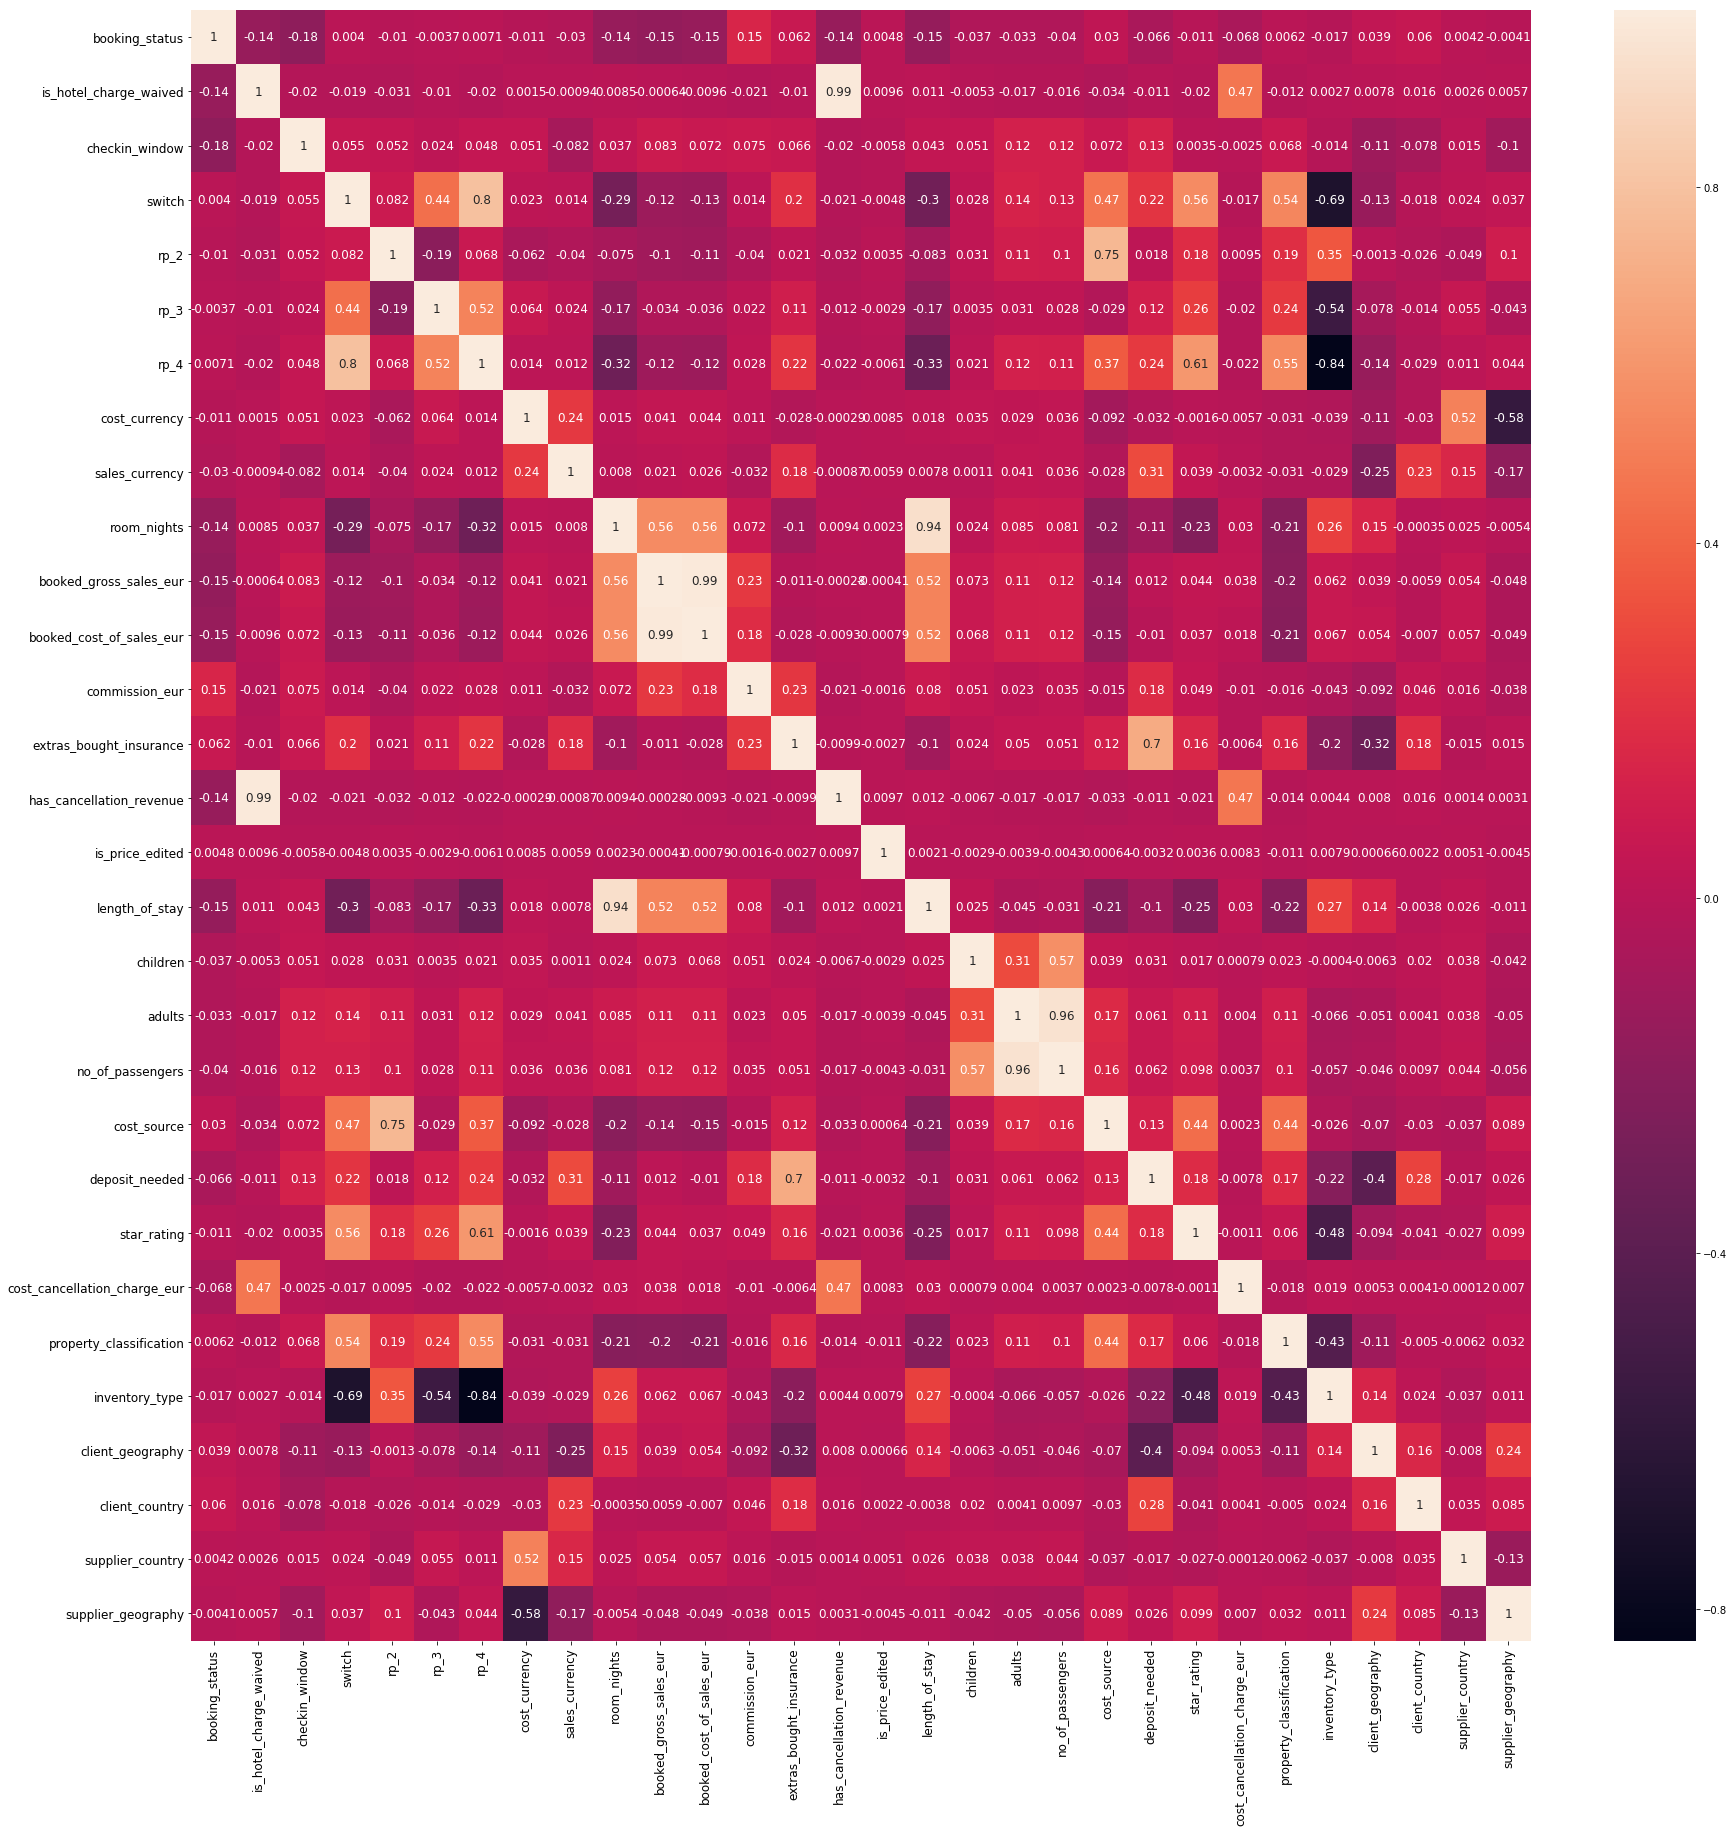

In [16]:
corr = df.corr()
sns.heatmap(corr, xticklabels=corr.columns.values, yticklabels=corr.columns.values, annot = True, annot_kws={'size':12})
heat_map=plt.gcf()
heat_map.set_size_inches(30,30)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

In [17]:
# Let's avoid multicolinearity. 
df.pop('booked_cost_of_sales_eur')
df.pop('star_rating')
df.pop('adults')
df.pop('cost_source')
df.pop('is_hotel_charge_waived')
df.pop('cost_currency')
df.pop('extras_bought_insurance')
df.pop('rp_4')

0         117
1         117
2         117
3         117
4         117
5         117
6         117
7         117
8         117
9         117
10        117
11        117
12        117
13        117
14        117
15        117
16        117
17        117
18        117
19        117
20        117
21        117
22        117
23        117
24        117
25        117
26        117
27        117
28        117
29        117
         ... 
228949      0
228950      0
228951      0
228952      7
228953      0
228954      0
228955      0
228956      0
228957      0
228958      0
228959      0
228960      0
228961      7
228962      0
228963      7
228964      0
228965      0
228966      0
228967     39
228968      0
228969      0
228970      0
228971      7
228972      0
228973     43
228974      0
228975      0
228976      0
228977     47
228978      0
Name: rp_4, Length: 228979, dtype: int8

## Split Test and Training Set
<span style="color:rgb(255, 0, 0);"> <b> NEED TO UPDATE SCIKIT LEARN IN GTA ENVIRONMENT </b></span>

In [19]:
#SPLIT DATA INTO TEST AND TRAINING SET
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size = 0.25)

train_y = train['booking_status']
test_y = test['booking_status']

train_x = train
train_x.pop('booking_status')
test_x = test
test_x.pop('booking_status')

178619    0
77115     0
100796    0
80339     0
160632    1
20607     1
2690      1
215448    0
64252     1
95837     1
174012    1
38756     1
22127     1
69443     1
145916    0
42796     0
8146      1
77693     0
140887    0
194745    0
166264    0
53080     0
43317     0
210785    1
31496     0
116747    1
65044     1
9080      1
125557    1
10021     1
         ..
165370    1
204092    1
147330    1
34787     0
162762    1
174539    0
100846    1
74446     1
224501    1
80959     1
24434     0
37187     1
76564     1
219220    0
40811     1
228162    1
173800    1
132879    0
147938    1
37532     1
104172    0
138805    1
63010     1
216450    1
23261     1
170043    1
82999     1
73774     1
101863    0
166805    1
Name: booking_status, Length: 57245, dtype: int8

## Train the sets on Logistic Regression

In [21]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report

logisticRegr = LogisticRegression(C=, max_iter=100)
logisticRegr.fit(X=train_x, y=train_y)

test_y_pred = logisticRegr.predict(test_x)
cfm = confusion_matrix(test_y, test_y_pred)
print('Intercept: ' + str(logisticRegr.intercept_))
print('Regression: ' + str(logisticRegr.coef_))
print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logisticRegr.score(test_x, test_y)))
print(classification_report(test_y, test_y_pred))


Intercept: [0.0948033]
Regression: [[-5.79906494e-03  5.37669367e-02 -1.82906780e-04  9.48206351e-07
   1.35887722e-03  2.54323048e-02 -7.38604665e-04  5.45819500e-01
  -2.06113795e-02  4.27773148e-04 -5.94092253e-02 -7.92691505e-02
   6.11770051e-02 -1.83641420e-01 -1.36264338e-01 -3.34188746e-02
   9.94790634e-02  2.73480734e-01  2.56579405e-03  2.11625841e-03
  -5.98765258e-02]]
Accuracy of logistic regression classifier on test set: 0.74
             precision    recall  f1-score   support

          0       0.64      0.32      0.42     17614
          1       0.75      0.92      0.83     39631

avg / total       0.72      0.74      0.70     57245



Text(0.5,15,'Predicted label')

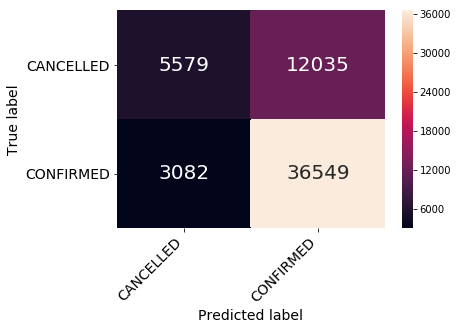

In [22]:
confusion_matrix_df = pd.DataFrame(cfm, ('CANCELLED', 'CONFIRMED'), ('CANCELLED', 'CONFIRMED'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)

In [23]:
df['booking_status'].value_counts()

1    158287
0     70692
Name: booking_status, dtype: int64

## Up-sampling the minority class

<p> There are much much more "NOT CANCELLED" than "CANCELLED" bookings - Cancelled in one of our samples was 31%. </p><p> In order to balance the data set, we can randomly duplicate observations from the minority class. This is also known as re sampling with replacement </p>

In [24]:
from sklearn.utils import resample

data_majority = df[df['booking_status']==1]
data_minority = df[df['booking_status']==0]

data_minority_upsampled = resample(data_minority,
replace=True,
n_samples=158287, #same number of samples as majority classe
random_state=1) #set the seed for random resampling
# Combine resampled results
data_upsampled = pd.concat([data_majority, data_minority_upsampled])

data_upsampled['booking_status'].value_counts()

1    158287
0    158287
Name: booking_status, dtype: int64

## Down-sampling
<span style="color:rgb(0, 0, 255);"> <b> Only used it if you need it </b></span>

In [367]:
data_majority = df[df['booking_status']==1]
data_minority = df[df['booking_status']==0]

data_majority_upsampled = resample(data_majority,
replace=True,
n_samples=1414692, #same number of samples as minority classe
random_state=1) #set the seed for random resampling
# Combine resampled results
data_upsampled = pd.concat([data_minority, data_majority_upsampled])

data_upsampled['booking_status'].value_counts()

1    1414692
0    1414692
Name: booking_status, dtype: int64

## RE-TRAIN

In [25]:
train, test = train_test_split(data_upsampled, test_size = 0.25)

train_y_upsampled = train['booking_status'] ###BIG DATASET: 75% of Data_unsamples
test_y_upsampled = test['booking_status']  ### SMALL DATASET : REST

train_x_upsampled = train 
train_x_upsampled.pop('booking_status') ## Makes it equal of 75% without booking_status
test_x_upsampled = test
test_x_upsampled.pop('booking_status') ## Makes it equal of 25% without booking status

logisticRegr_balanced = LogisticRegression(C=1, max_iter=100)
logisticRegr_balanced.fit(X=train_x_upsampled, y=train_y_upsampled)

test_y_pred_balanced = logisticRegr_balanced.predict(test_x_upsampled)

cfm2 = confusion_matrix(test_y_upsampled, test_y_pred_balanced)

print('Accuracy of logistic regression classifier on test set: {:.2f}'.format(logisticRegr_balanced.score(test_x_upsampled, test_y_upsampled)))
print(classification_report(test_y_upsampled, test_y_pred_balanced))

Accuracy of logistic regression classifier on test set: 0.71
             precision    recall  f1-score   support

          0       0.71      0.70      0.70     39480
          1       0.70      0.72      0.71     39664

avg / total       0.71      0.71      0.71     79144



Text(0.5,15,'Predicted label')

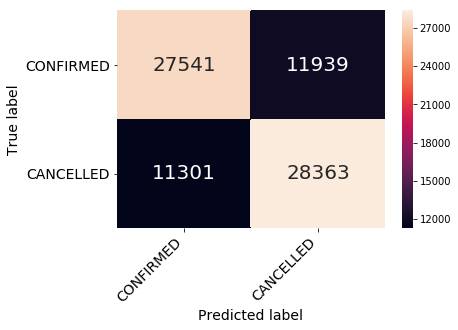

In [27]:
confusion_matrix_df = pd.DataFrame(cfm2, ('CONFIRMED', 'CANCELLED'), ('CONFIRMED', 'CANCELLED'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('True label', fontsize = 14)
plt.xlabel('Predicted label', fontsize = 14)

## Model Performance with AUROC
<p> Area Under ROC Curve (AUROC) represents the likelihood of a model distinguishing observations between two classes. In very simple terms, AUROC gives a single measure of how a model’s true positive rate and false positive rate change with different threshold values. The closer a model’s AUROC score is to 1, the better it is. To calculate AUROC, we need the predicted class probabilities </p>

In [28]:
from sklearn.metrics import roc_auc_score

# Get class probabilities for both models
test_y_prob = logisticRegr.predict_proba(test_x)
test_y_prob_balanced = logisticRegr_balanced.predict_proba(test_x_upsampled)

# We only need the probabilities for the positive class
test_y_prob = [p[1] for p in test_y_prob]
test_y_prob_balanced = [p[1] for p in test_y_prob_balanced]

print('Unbalanced model AUROC: ' + str(roc_auc_score(test_y, test_y_prob)))
print('Balanced model AUROC: ' + str(roc_auc_score(test_y_upsampled, test_y_prob_balanced)))

Unbalanced model AUROC: 0.7675727535934231
Balanced model AUROC: 0.7917459637142473


## ROC Curve
<p> Basically, if it's above the baseline then it's good model </p>

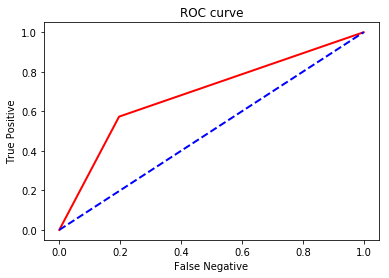

In [29]:
##Computing false and true positive rates
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score

fpr, tpr,_=roc_curve(logisticRegr.predict(train_x_upsampled),train_y_upsampled,drop_intermediate=False)

import matplotlib.pyplot as plt
plt.figure()
##Adding the ROC
plt.plot(fpr, tpr, color='red',
 lw=2, label='ROC curve')
##Random FPR and TPR
plt.plot([0, 1], [0, 1], color='blue', lw=2, linestyle='--')
##Title and label
plt.xlabel('False Negative')
plt.ylabel('True Positive')
plt.title('ROC curve')
plt.show()

## Let's make an actual prediction for bookings on 13/07

In [30]:
# Gets the data from Snowflake
eng = create_engine(
    'snowflake://{user}:{password}@{account}/'.format(
        user='BTRENTINI',
        password='bruno@253987Nt',
        account='gta.eu-central-1',
    )
)
try:
    connection = eng.connect()
    results = connection.execute('select current_version()').fetchone()
    print("Snowflake version: ",results[0])
finally:
    connection.close()

    
a = "PROD_REPORT"
b = "PROD_ANALYTICS"
c = "TABLEAU"

warehouse = 'USE WAREHOUSE ' + a + ';'
db = 'USE DATABASE ' + b + ';'
schema = 'USE SCHEMA ' + c + ';'

eng.execute(warehouse)
eng.execute(db)
eng.execute(schema)

query = """SELECT 
            UNIQUE_BOOKING_ID
            ,BOOKING_STATUS
            ,CHECKIN_WINDOW
            ,split_part(RATE_PLAN_BKEY, '|', 1) AS "SWITCH"
            ,split_part(RATE_PLAN_BKEY, '|', 2) AS "RP_2"
            ,split_part(RATE_PLAN_BKEY, '|', 3) AS "RP_3"
            ,SALES_CURRENCY
            ,ROOM_NIGHTS
            ,BOOKED_GROSS_SALES_EUR
            ,COMMISSION_EUR
            ,COST_ADJUSTMENT_CHARGE_EUR
            ,HAS_CANCELLATION_REVENUE
            ,IS_PRICE_EDITED
            ,LENGTH_OF_STAY
            ,CHILDREN
            ,ADULTS
            ,NO_OF_PASSENGERS
            ,DEPOSIT_NEEDED
            ,COST_CANCELLATION_CHARGE_EUR
            ,PROPERTY_CLASSIFICATION
            ,INVENTORY_TYPE
            ,CLIENT_GEOGRAPHY
            ,CLIENT_COUNTRY
            ,SUPPLIER_COUNTRY
            ,SUPPLIER_GEOGRAPHY 
            FROM SPOT_EXTRACT_1 
            WHERE CREATION_DATE BETWEEN '2018-07-13 00:00:01' AND '2018-07-13 23:59:56';
        """

bookings = pd.read_sql(query, eng)
eng.dispose()

Snowflake version:  2.54.2


In [31]:
bookings_day_x = bookings.copy()

In [46]:
bookings_day_x.shape

(23127, 24)

In [34]:
print((len(bookings_day_x.columns.values)))
print("----")
print((len(data_upsampled.columns.values)))

import numpy as np
list_1 = list(bookings_day_x.columns.values)
list_2 = list(data_upsampled.columns.values)
main_list = np.setdiff1d(list_1,list_2)
print(main_list)

22
----
22
[]


In [33]:
bookings_day_x.pop('adults')
bookings_day_x.pop('cost_adjustment_charge_eur')
bookings_day_x.pop('unique_booking_id')

0        1026245704
1         442453734
2        1026243806
3          34288946
4        1026247651
5        1026243444
6          34288998
7        1026241820
8          83220825
9         442454575
10       2820318263
11       1026241732
12        124251420
13       2820318692
14        163725599
15         20414611
16         34288999
17       1026248327
18       1026241773
19       1026243704
20        442427162
21        442454843
22         83197966
23       1026211288
24        442454314
25        124209037
26        442454969
27        163724394
28       1026242259
29       1026247806
            ...    
23097    1026244401
23098     141144770
23099     412259254
23100     261737267
23101    1026243224
23102    1026247492
23103    2820318766
23104     442454877
23105     191838066
23106     171340494
23107     191837901
23108    1026248720
23109    1026242177
23110    1026246545
23111    1026242681
23112     171340906
23113     261737901
23114     124242664
23115     171340392


In [35]:
bookings_day_x['checkin_window'].fillna(0,inplace=True)
bookings_day_x['switch'].fillna('n.a.',inplace=True)
bookings_day_x['rp_2'].fillna('n.a.',inplace=True)
bookings_day_x['rp_3'].fillna('n.a.',inplace=True)
bookings_day_x['sales_currency'].fillna('n.a.',inplace=True)
bookings_day_x['room_nights'].fillna(0,inplace=True)
bookings_day_x['booked_gross_sales_eur'].fillna(0,inplace=True)
bookings_day_x['commission_eur'].fillna(0,inplace=True)
bookings_day_x['cost_cancellation_charge_eur'].fillna(0,inplace=True)
bookings_day_x['has_cancellation_revenue'].fillna('n.a.',inplace=True)
bookings_day_x['is_price_edited'].fillna('n.a.',inplace=True)
bookings_day_x['length_of_stay'].fillna(0,inplace=True)
bookings_day_x['children'].fillna(99999,inplace=True)
bookings_day_x['no_of_passengers'].fillna(99999,inplace=True)
bookings_day_x['deposit_needed'].fillna('n.a.',inplace=True)
bookings_day_x['cost_cancellation_charge_eur'].fillna(99999,inplace=True)
bookings_day_x['property_classification'].fillna('n.a.',inplace=True)
bookings_day_x['inventory_type'].fillna('n.a.',inplace=True)
bookings_day_x['client_geography'].fillna('n.a.',inplace=True)
bookings_day_x['client_country'].fillna('n.a.',inplace=True)
bookings_day_x['supplier_country'].fillna('n.a.',inplace=True)
bookings_day_x['supplier_geography'].fillna('n.a.',inplace=True)
bookings_day_x['cost_cancellation_charge_eur'].fillna(0,inplace=True)

In [36]:
import time
t0 = time.time()
print("This process can take a while... There are 21 features to transform")

bookings_day_x.checkin_window = pd.Categorical(bookings_day_x.checkin_window)
bookings_day_x['checkin_window'] = bookings_day_x.checkin_window.cat.codes

bookings_day_x.switch = pd.Categorical(bookings_day_x.switch)
bookings_day_x['switch'] = bookings_day_x.switch.cat.codes

bookings_day_x.rp_2 = pd.Categorical(bookings_day_x.rp_2)
bookings_day_x['rp_2'] = bookings_day_x.rp_2.cat.codes

bookings_day_x.rp_3 = pd.Categorical(bookings_day_x.rp_3)
bookings_day_x['rp_3'] = bookings_day_x.rp_3.cat.codes

bookings_day_x.sales_currency = pd.Categorical(bookings_day_x.sales_currency)
bookings_day_x['sales_currency'] = bookings_day_x.sales_currency.cat.codes

#room_nights
#booked_gross_sales_eur
#booked_cost_of_sales_eur
#commission_eur
#cost_adjustment_charge_eur


bookings_day_x.has_cancellation_revenue = pd.Categorical(bookings_day_x.has_cancellation_revenue)
bookings_day_x['has_cancellation_revenue'] = bookings_day_x.has_cancellation_revenue.cat.codes

bookings_day_x.is_price_edited = pd.Categorical(bookings_day_x.is_price_edited)
bookings_day_x['is_price_edited'] = bookings_day_x.is_price_edited.cat.codes

#length_of_stay
#children
#adults
#infants
#no_of_passengers


bookings_day_x.deposit_needed = pd.Categorical(bookings_day_x.deposit_needed)
bookings_day_x['deposit_needed'] = bookings_day_x.deposit_needed.cat.codes

#cost_cancellation_charge_eur

bookings_day_x.property_classification = pd.Categorical(bookings_day_x.property_classification)
bookings_day_x['property_classification'] = bookings_day_x.property_classification.cat.codes

bookings_day_x.inventory_type = pd.Categorical(bookings_day_x.inventory_type)
bookings_day_x['inventory_type'] = bookings_day_x.inventory_type.cat.codes

bookings_day_x.client_geography = pd.Categorical(bookings_day_x.client_geography)
bookings_day_x['client_geography'] = bookings_day_x.client_geography.cat.codes

bookings_day_x.client_country = pd.Categorical(bookings_day_x.client_country)
bookings_day_x['client_country'] = bookings_day_x.client_country.cat.codes

bookings_day_x.supplier_country = pd.Categorical(bookings_day_x.supplier_country)
bookings_day_x['supplier_country'] = bookings_day_x.supplier_country.cat.codes

bookings_day_x.supplier_geography = pd.Categorical(bookings_day_x.supplier_geography)
bookings_day_x['supplier_geography'] = bookings_day_x.supplier_geography.cat.codes

# Legacy
#bookings_day_x['booking_status'].replace(list(bookings_day_x.booking_status.unique()), [x for x,y in enumerate(list(bookings_day_x.booking_status.unique()))],inplace=True)

t1 = time.time()
print(t1-t0)

This process can take a while... There are 21 features to transform
0.14842581748962402


In [37]:
train_y = data_upsampled['booking_status']
train_x = data_upsampled.iloc[:,1:]
test_set = bookings_day_x.iloc[:,1:] #Sekect Booking_status

In [38]:
model = LogisticRegression()
model.fit(X=train_x, y=train_y)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [39]:
probabilities = model.predict_proba(test_set)

In [40]:
predictions = model.predict(test_set)

In [41]:
bookings_day_x['predictions'] = predictions[:]

In [47]:
print(probabilities[:][0])

[0.30015586 0.69984414]


In [42]:
bookings_day_x['prob_cancel'] = list(probabilities[:])

In [43]:
bookings_day_x.head()

,booking_status,checkin_window,switch,rp_2,rp_3,sales_currency,room_nights,booked_gross_sales_eur,commission_eur,has_cancellation_revenue,...,deposit_needed,cost_cancellation_charge_eur,property_classification,inventory_type,client_geography,client_country,supplier_country,supplier_geography,predictions,prob_cancel
0,Confirmed,42,6,177,8556,22,0.0,27.8230,0.0000,0,...,0,0.0,6,0,2,92,117,3,1,"[0.36329513782560496, 0.636704862174395]"
1,Confirmed,280,6,177,8556,22,0.0,118.5686,16.5996,0,...,1,0.0,6,0,0,93,41,2,1,"[0.0, 1.0]"
2,Confirmed,23,6,177,8556,23,0.0,245.1966,36.7795,0,...,0,0.0,6,0,3,79,70,0,1,"[0.0, 1.0]"
3,Confirmed,104,6,177,8556,22,0.0,154.0964,21.5735,0,...,0,0.0,6,0,0,93,118,2,1,"[0.0, 1.0]"
4,Confirmed,33,6,177,8556,22,0.0,230.2885,0.0000,0,...,0,0.0,6,0,0,57,11,2,1,"[0.4441737383482166, 0.5558262616517834]"


In [44]:
bookings_day_x.to_csv('predictions.csv')

In [45]:
model.get_params(deep=True)

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'max_iter': 100,
 'multi_class': 'ovr',
 'n_jobs': 1,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}